## 1. Environment Setup
Loading necessary libraries and configuring the analysis environment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


## 2. Data Loading & Initial Inspection
Understanding the structure and content of the movies dataset.

In [2]:
df = pd.read_csv(r'C:\Users\Leverson Batista\Documents\Data_Portfolio\movie-correlation-python\data\raw\movies.csv')

# Dataset overview
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")

# Display first rows
df.head()

Dataset Shape: 7,668 rows × 15 columns



,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.40,927000.00,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.00,46998772.00,Warner Bros.,146.00
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.80,65000.00,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.00,58853106.00,Columbia Pictures,104.00
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.70,1200000.00,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.00,538375067.00,Lucasfilm,124.00
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.70,221000.00,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.00,83453539.00,Paramount Pictures,88.00
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.30,108000.00,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.00,39846344.00,Orion Pictures,98.00


## 3. Data Quality Assessment
Identifying missing values and data quality issues that need to be addressed.

In [3]:
# Missing values analysis
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    'Missing_Count', ascending=False
).reset_index(drop=True)

display(missing_data)

# Budget and Revenue quality check
quality_check = pd.DataFrame({
    'Metric': [
        'Total Records',
        'Missing Budget',
        'Missing Revenue',
        'Zero Budget',
        'Zero Revenue',
        'Valid Budget Records',
        'Valid Revenue Records',
        'Usable for Analysis'
    ],
    'Count': [
        len(df),
        df['budget'].isnull().sum(),
        df['gross'].isnull().sum(),
        (df['budget'] == 0).sum(),
        (df['gross'] == 0).sum(),
        ((df['budget'].notna()) & (df['budget'] > 0)).sum(),
        ((df['gross'].notna()) & (df['gross'] > 0)).sum(),
        ((df['budget'].notna()) & (df['budget'] > 0) & 
         (df['gross'].notna()) & (df['gross'] > 0)).sum()
    ]
})

display(quality_check)

,Column,Missing_Count,Missing_Percentage
0,budget,2171,28.31
1,gross,189,2.46
2,rating,77,1.00
3,company,17,0.22
4,runtime,4,0.05
5,writer,3,0.04
6,score,3,0.04
7,votes,3,0.04
8,country,3,0.04
9,released,2,0.03


,Metric,Count
0,Total Records,7668
1,Missing Budget,2171
2,Missing Revenue,189
3,Zero Budget,0
4,Zero Revenue,0
5,Valid Budget Records,5497
6,Valid Revenue Records,7479
7,Usable for Analysis,5436


## 4. Data Cleaning & Feature Engineering
Preparing the dataset for analysis by removing invalid records and creating financial metrics (Profit and ROI).

In [4]:
df_clean = df.copy()

# Remove records without valid budget and revenue
df_clean = df_clean[
    (df_clean['budget'].notna()) & 
    (df_clean['budget'] > 0) &
    (df_clean['gross'].notna()) & 
    (df_clean['gross'] > 0)
].reset_index(drop=True)

# Create financial metrics
df_clean['profit'] = df_clean['gross'] - df_clean['budget']
df_clean['roi'] = ((df_clean['gross'] - df_clean['budget']) / df_clean['budget']) * 100

# Cleaning summary
cleaning_summary = pd.DataFrame({
    'Stage': ['Original Dataset', 'After Cleaning', 'Records Removed', 'Data Retention %'],
    'Count': [
        len(df),
        len(df_clean),
        len(df) - len(df_clean),
        f"{(len(df_clean) / len(df) * 100):.1f}%"
    ]
})

display(cleaning_summary)

# Display sample of cleaned data with new features
df_clean[['name', 'budget', 'gross', 'profit', 'roi']].head(10)

,Stage,Count
0,Original Dataset,7668
1,After Cleaning,5436
2,Records Removed,2232
3,Data Retention %,70.9%


,name,budget,gross,profit,roi
0,The Shining,19000000.00,46998772.00,27998772.00,147.36
1,The Blue Lagoon,4500000.00,58853106.00,54353106.00,1207.85
2,Star Wars: Episode V - The Empire Strikes Back,18000000.00,538375067.00,520375067.00,2890.97
3,Airplane!,3500000.00,83453539.00,79953539.00,2284.39
4,Caddyshack,6000000.00,39846344.00,33846344.00,564.11
5,Friday the 13th,550000.00,39754601.00,39204601.00,7128.11
6,The Blues Brothers,27000000.00,115229890.00,88229890.00,326.78
7,Raging Bull,18000000.00,23402427.00,5402427.00,30.01
8,Superman II,54000000.00,108185706.00,54185706.00,100.34
9,The Long Riders,10000000.00,15795189.00,5795189.00,57.95


## 5. Exploratory Data Analysis (EDA)

### 5.1 Statistical Summary
Descriptive statistics of key financial metrics to understand central tendency, spread, and range of values.

In [11]:
financial_summary = df_clean[['budget', 'gross', 'profit', 'roi']].describe().T
financial_summary['median'] = df_clean[['budget', 'gross', 'profit', 'roi']].median().values
financial_summary = financial_summary[['count', 'mean', 'median', 'std', 'min', 'max']]

display(financial_summary)

,count,mean,median,std,min,max
budget,5436.00,35938637.62,21000000.00,41547704.90,6000.00,356000000.00
gross,5436.00,103004458.12,36711988.00,187105108.71,309.00,2847246203.00
profit,5436.00,67065820.50,13766118.00,158818096.74,-158031147.00,2610246203.00
roi,5436.00,571.93,83.29,18384.32,-100.00,1288938.67


### 5.2 Distribution Analysis
Visualizing the distribution of financial metrics through histograms to identify patterns and skewness.

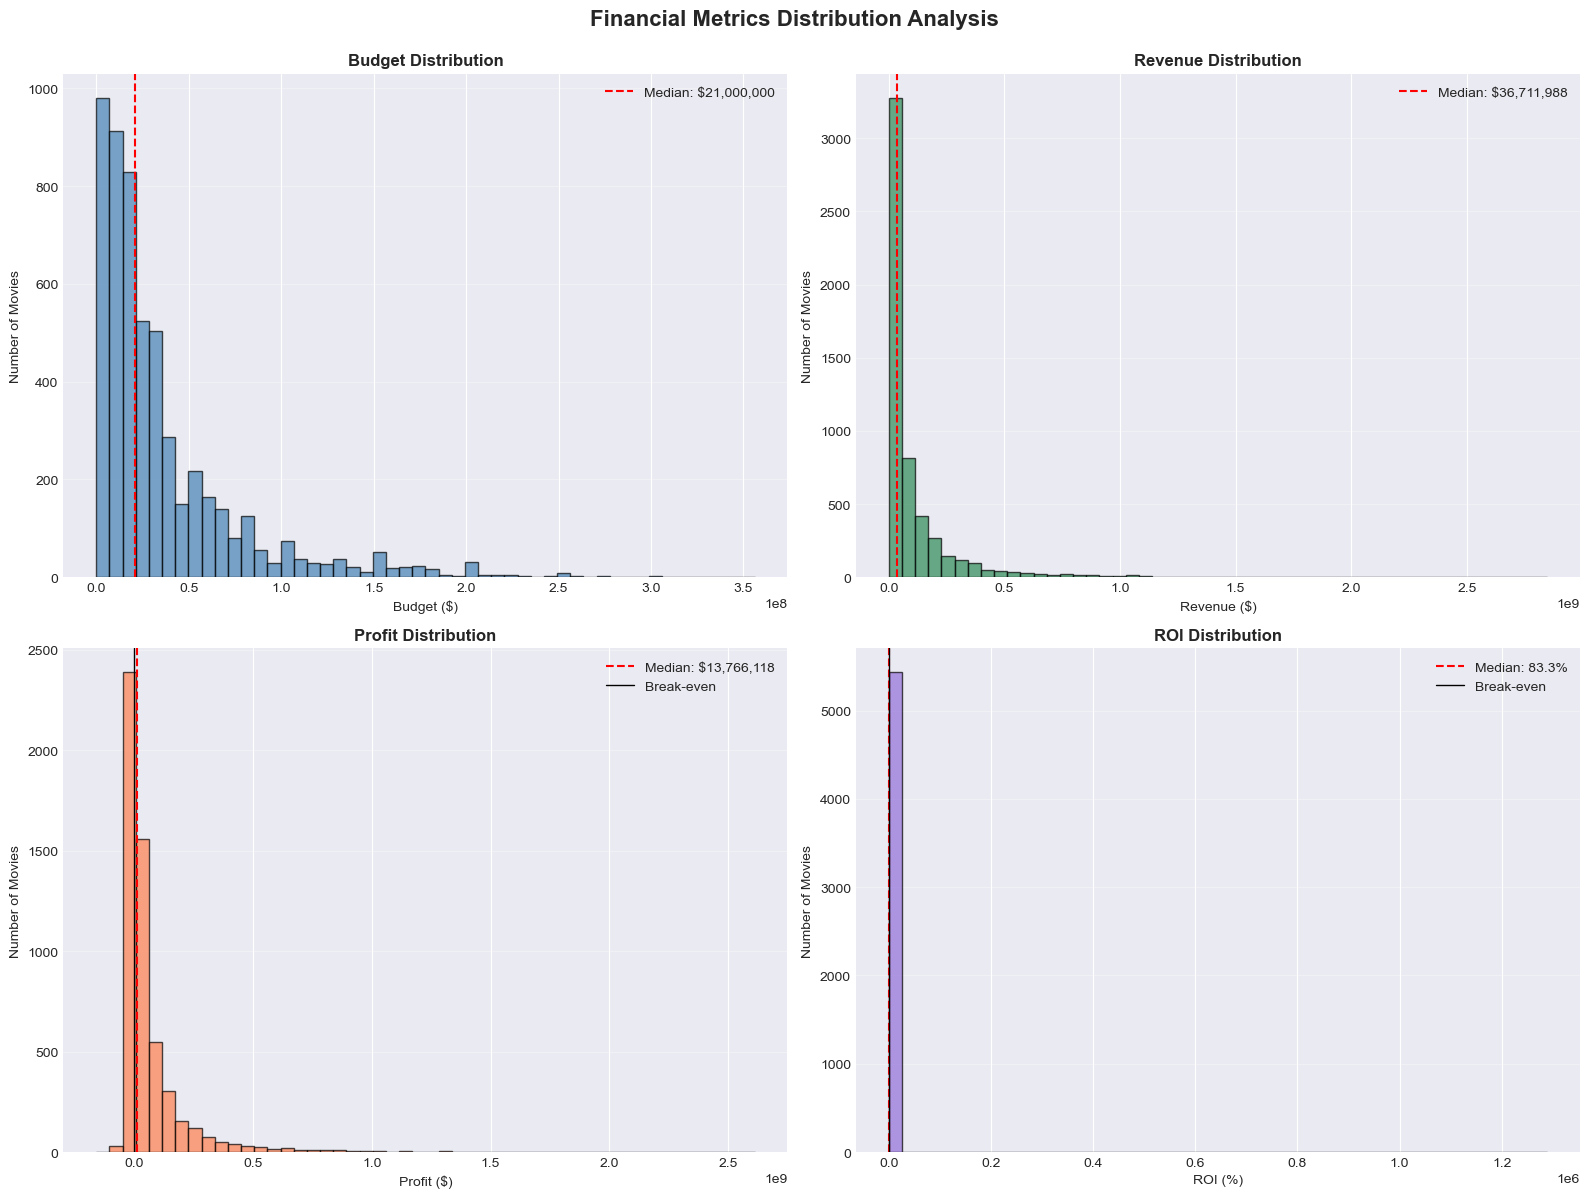

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Financial Metrics Distribution Analysis', fontsize=16, fontweight='bold', y=0.995)

# Budget distribution
axes[0, 0].hist(df_clean['budget'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Budget Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Budget ($)')
axes[0, 0].set_ylabel('Number of Movies')
axes[0, 0].axvline(df_clean['budget'].median(), color='red', linestyle='--', 
                    label=f"Median: ${df_clean['budget'].median():,.0f}")
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Revenue distribution
axes[0, 1].hist(df_clean['gross'], bins=50, color='seagreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Revenue Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Revenue ($)')
axes[0, 1].set_ylabel('Number of Movies')
axes[0, 1].axvline(df_clean['gross'].median(), color='red', linestyle='--', 
                    label=f"Median: ${df_clean['gross'].median():,.0f}")
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Profit distribution
axes[1, 0].hist(df_clean['profit'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Profit Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Profit ($)')
axes[1, 0].set_ylabel('Number of Movies')
axes[1, 0].axvline(df_clean['profit'].median(), color='red', linestyle='--', 
                    label=f"Median: ${df_clean['profit'].median():,.0f}")
axes[1, 0].axvline(0, color='black', linestyle='-', linewidth=1, label='Break-even')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# ROI distribution
axes[1, 1].hist(df_clean['roi'], bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('ROI Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('ROI (%)')
axes[1, 1].set_ylabel('Number of Movies')
axes[1, 1].axvline(df_clean['roi'].median(), color='red', linestyle='--', 
                    label=f"Median: {df_clean['roi'].median():.1f}%")
axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=1, label='Break-even')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Outlier Detection and Top Performers
Identifying extreme values through boxplots and highlighting the most successful movies by profit and ROI.

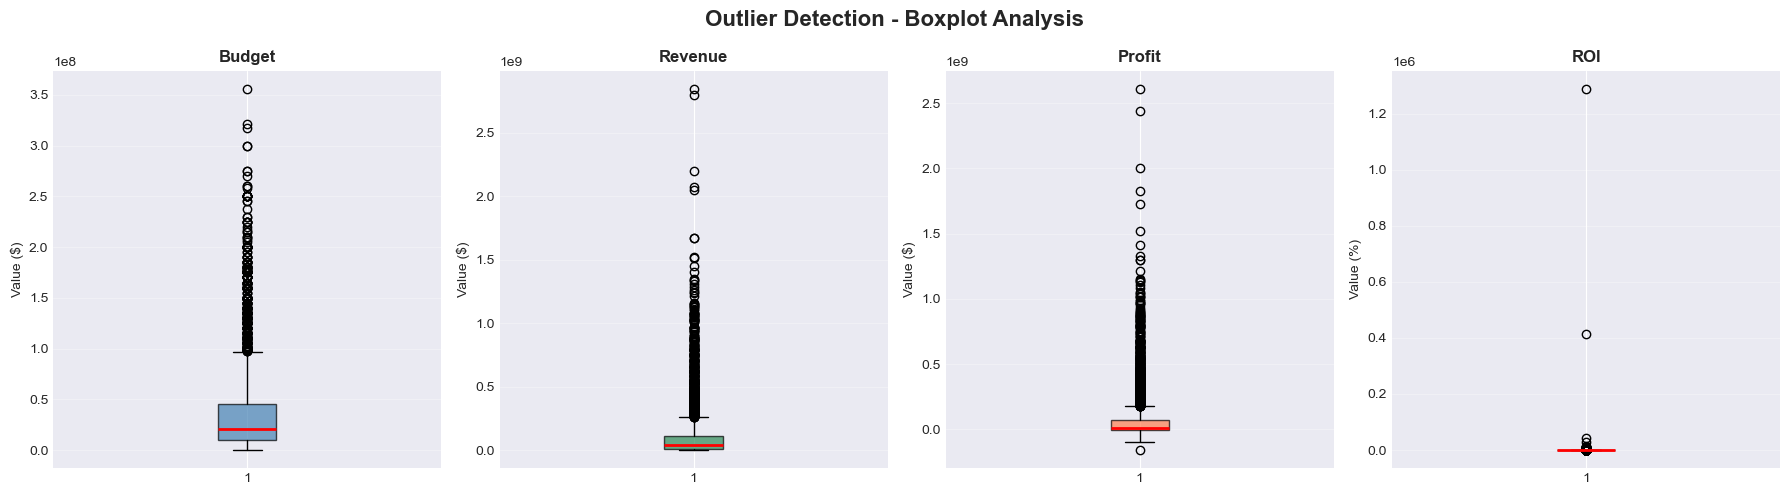

Top 10 Most Profitable Movies:


,name,budget,gross,profit,roi
3743,Avatar,237000000.00,2847246203.00,2610246203.00,1101.37
5316,Avengers: Endgame,356000000.00,2797501328.00,2441501328.00,685.81
1802,Titanic,200000000.00,2201647264.00,2001647264.00,1000.82
4743,Star Wars: Episode VII - The Force Awakens,245000000.00,2069521700.00,1824521700.00,744.70
5172,Avengers: Infinity War,321000000.00,2048359754.00,1727359754.00,538.12
4733,Jurassic World,150000000.00,1670516444.00,1520516444.00,1013.68
5348,The Lion King,260000000.00,1670727580.00,1410727580.00,542.59
4726,Furious 7,190000000.00,1515341399.00,1325341399.00,697.55
5360,Frozen II,150000000.00,1450026933.00,1300026933.00,866.68
4236,The Avengers,220000000.00,1518815515.00,1298815515.00,590.37



Top 10 Highest ROI Movies:


,name,budget,gross,profit,roi
3478,Paranormal Activity,15000.00,193355800.00,193340800.00,1288938.67
2114,The Blair Witch Project,60000.00,248639099.00,248579099.00,414298.50
4864,The Gallows,100000.00,42964410.00,42864410.00,42864.41
1160,El Mariachi,7000.00,2040920.00,2033920.00,29056.00
3510,Once,150000.00,20936722.00,20786722.00,13857.81
1411,Clerks,27000.00,3151130.00,3124130.00,11570.85
2947,Napoleon Dynamite,400000.00,46138887.00,45738887.00,11434.72
1947,In the Company of Men,25000.00,2804473.00,2779473.00,11117.89
3231,Keeping Mum,169000.00,18586834.00,18417834.00,10898.13
2823,Open Water,500000.00,54683487.00,54183487.00,10836.70


In [13]:
# Boxplot analysis
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle('Outlier Detection - Boxplot Analysis', fontsize=16, fontweight='bold')

metrics = ['budget', 'gross', 'profit', 'roi']
colors = ['steelblue', 'seagreen', 'coral', 'mediumpurple']
titles = ['Budget', 'Revenue', 'Profit', 'ROI']

for idx, (metric, color, title) in enumerate(zip(metrics, colors, titles)):
    axes[idx].boxplot(df_clean[metric], vert=True, patch_artist=True,
                      boxprops=dict(facecolor=color, alpha=0.7),
                      medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Value ($)' if metric != 'roi' else 'Value (%)')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Top performers
top_profitable = df_clean.nlargest(10, 'profit')[['name', 'budget', 'gross', 'profit', 'roi']]
top_roi = df_clean.nlargest(10, 'roi')[['name', 'budget', 'gross', 'profit', 'roi']]

print("Top 10 Most Profitable Movies:")
display(top_profitable)

print("\nTop 10 Highest ROI Movies:")
display(top_roi)

## 6. Correlation Analysis
Investigate the relationship between budget and revenue to answer our main research question.

Correlation Matrix:


,budget,gross,profit,roi
budget,1.00,0.74,0.61,-0.02
gross,0.74,1.00,0.98,0.02
profit,0.61,0.98,1.00,0.02
roi,-0.02,0.02,0.02,1.00



Budget vs Revenue Correlation: 0.7404
   Pearson Correlation Coefficient: 0.7404
   P-value: 0.00e+00
   ✓ Highly statistically significant (p < 0.001)


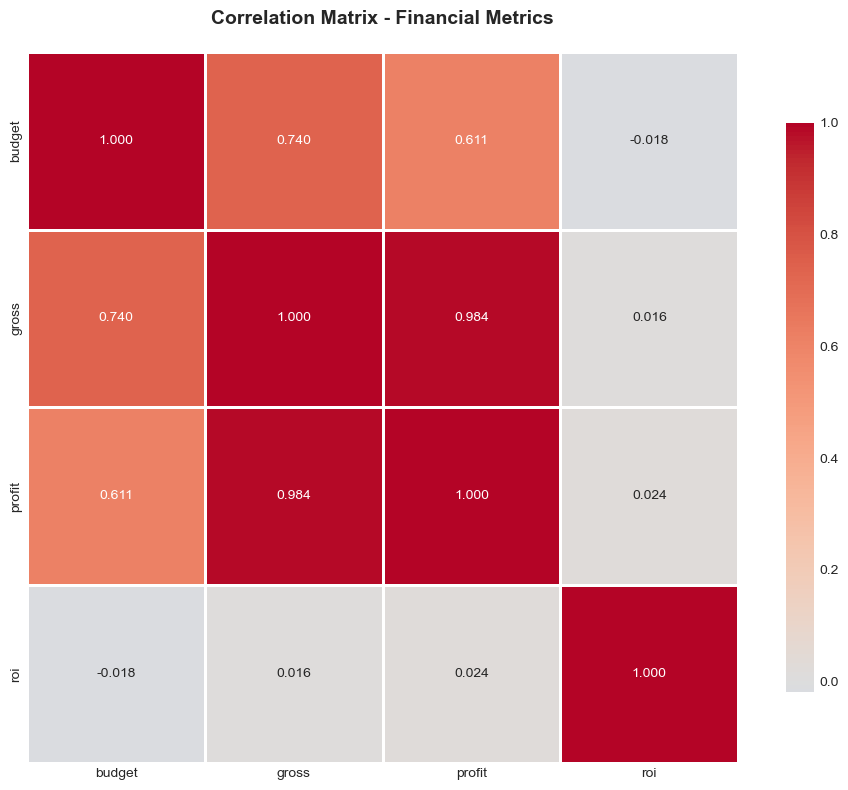

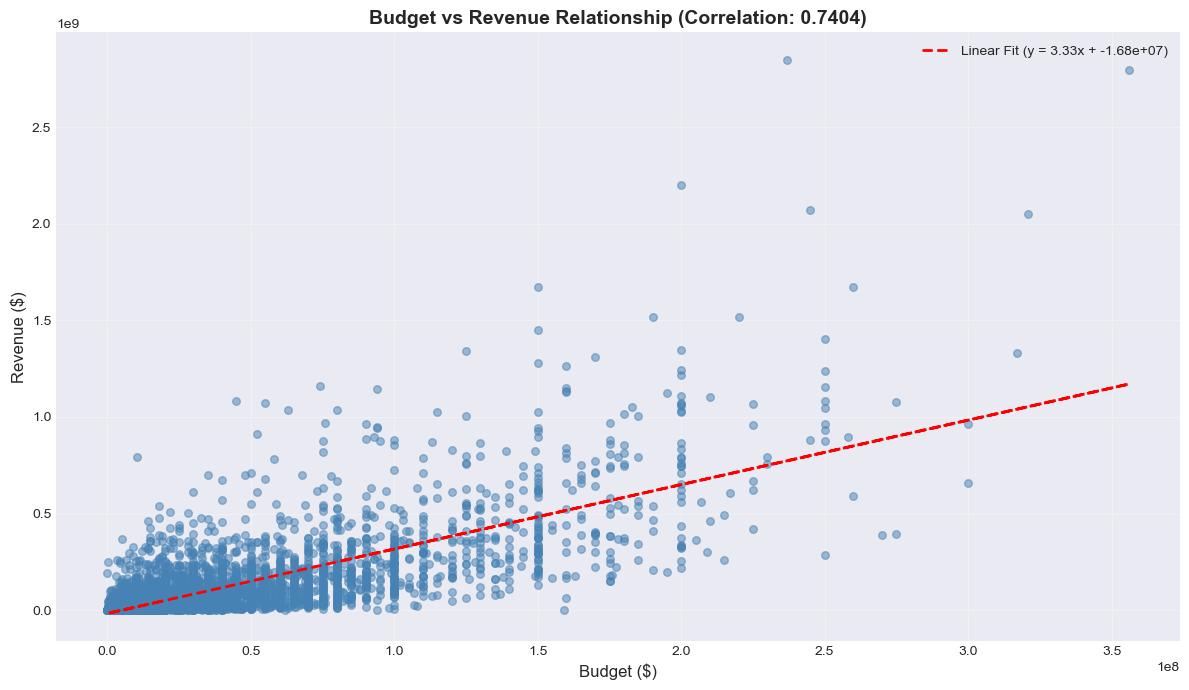


R-squared (R²): 0.5482
   Interpretation: Budget explains 54.82% of the variance in revenue


In [14]:

# Calculate correlation matrix
correlation_matrix = df_clean[['budget', 'gross', 'profit', 'roi']].corr()

print("Correlation Matrix:")
display(correlation_matrix)

# Focus on budget-revenue correlation
budget_revenue_corr = df_clean['budget'].corr(df_clean['gross'])
print(f"\nBudget vs Revenue Correlation: {budget_revenue_corr:.4f}")

# Statistical significance test (Pearson correlation)
corr_coefficient, p_value = stats.pearsonr(df_clean['budget'], df_clean['gross'])
print(f"   Pearson Correlation Coefficient: {corr_coefficient:.4f}")
print(f"   P-value: {p_value:.2e}")

if p_value < 0.001:
    print("   ✓ Highly statistically significant (p < 0.001)")
elif p_value < 0.05:
    print("   ✓ Statistically significant (p < 0.05)")
else:
    print("   ✗ Not statistically significant (p >= 0.05)")

# Visualize correlation with heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Financial Metrics', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Scatter plot: Budget vs Revenue
plt.figure(figsize=(12, 7))
plt.scatter(df_clean['budget'], df_clean['gross'], alpha=0.5, s=30, color='steelblue')

# Add regression line
z = np.polyfit(df_clean['budget'], df_clean['gross'], 1)
p = np.poly1d(z)
plt.plot(df_clean['budget'], p(df_clean['budget']), "r--", linewidth=2, 
         label=f'Linear Fit (y = {z[0]:.2f}x + {z[1]:.2e})')

plt.xlabel('Budget ($)', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
plt.title(f'Budget vs Revenue Relationship (Correlation: {budget_revenue_corr:.4f})', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Additional insight: Calculate what percentage of variance is explained
r_squared = budget_revenue_corr ** 2
print(f"\nR-squared (R²): {r_squared:.4f}")
print(f" Interpretation: Budget explains {r_squared*100:.2f}% of the variance in revenue")

## 7. Key Insights and Conclusions
Summarizing the main findings from our analysis and their business implications for the film industry.

In [16]:
# Summary statistics for presentation
insights_data = {
    'Metric': [
        'Total Movies Analyzed',
        'Average Budget',
        'Average Revenue',
        'Average Profit',
        'Average ROI',
        'Budget-Revenue Correlation',
        'R² (Variance Explained)',
        'Profitable Movies %'
    ],
    'Value': [
        f"{len(df_clean):,}",
        f"${df_clean['budget'].mean():,.0f}",
        f"${df_clean['gross'].mean():,.0f}",
        f"${df_clean['profit'].mean():,.0f}",
        f"{df_clean['roi'].mean():.2f}%",
        f"{budget_revenue_corr:.4f}",
        f"{r_squared:.4f} ({r_squared*100:.2f}%)",
        f"{(df_clean['profit'] > 0).sum() / len(df_clean) * 100:.1f}%"
    ]
}

insights_summary = pd.DataFrame(insights_data)
print("=" * 60)
print("ANALYSIS SUMMARY")
print("=" * 60)
display(insights_summary)

# Key findings
print("\n" + "=" * 60)
print("KEY FINDINGS")
print("=" * 60)

print("\nSTRONG POSITIVE CORRELATION")
print(f"   • Budget and revenue show a correlation of {budget_revenue_corr:.4f}")
print(f"   • This relationship is highly statistically significant (p < 0.001)")
print(f"   • Budget explains {r_squared*100:.2f}% of revenue variance")

print("\nPROFITABILITY INSIGHTS")
profitable_pct = (df_clean['profit'] > 0).sum() / len(df_clean) * 100
print(f"   • {profitable_pct:.1f}% of movies are profitable")
print(f"   • Median ROI: {df_clean['roi'].median():.1f}%")
print(f"   • Average profit per movie: ${df_clean['profit'].mean():,.0f}")

print("\nBUDGET RANGES")
budget_quartiles = df_clean['budget'].quantile([0.25, 0.5, 0.75])
print(f"   • Low budget (Q1): ${budget_quartiles[0.25]:,.0f}")
print(f"   • Medium budget (Q2): ${budget_quartiles[0.50]:,.0f}")
print(f"   • High budget (Q3): ${budget_quartiles[0.75]:,.0f}")

print("\nOUTLIERS & EXTREMES")
print(f"   • Highest profit: {df_clean.nlargest(1, 'profit')['name'].values[0]}")
print(f"     (${df_clean['profit'].max():,.0f})")
print(f"   • Highest ROI: {df_clean.nlargest(1, 'roi')['name'].values[0]}")
print(f"     ({df_clean['roi'].max():.1f}%)")

print("\n" + "=" * 60)
print("BUSINESS IMPLICATIONS")
print("=" * 60)
print("""
✓ Higher budgets are associated with higher revenues, but not guaranteed
✓ Budget is an important factor but explains only ~56% of revenue variance
✓ Other factors (marketing, cast, genre, timing) play significant roles
✓ ROI varies significantly - high budget doesn't always mean high ROI
✓ Strategic budget allocation should consider market conditions and risk
""")


ANALYSIS SUMMARY


,Metric,Value
0,Total Movies Analyzed,"5,436"
1,Average Budget,"$35,938,638"
2,Average Revenue,"$103,004,458"
3,Average Profit,"$67,065,821"
4,Average ROI,571.93%
5,Budget-Revenue Correlation,0.7404
6,R² (Variance Explained),0.5482 (54.82%)
7,Profitable Movies %,67.8%



KEY FINDINGS

STRONG POSITIVE CORRELATION
   • Budget and revenue show a correlation of 0.7404
   • This relationship is highly statistically significant (p < 0.001)
   • Budget explains 54.82% of revenue variance

PROFITABILITY INSIGHTS
   • 67.8% of movies are profitable
   • Median ROI: 83.3%
   • Average profit per movie: $67,065,821

BUDGET RANGES
   • Low budget (Q1): $10,000,000
   • Medium budget (Q2): $21,000,000
   • High budget (Q3): $45,000,000

OUTLIERS & EXTREMES
   • Highest profit: Avatar
     ($2,610,246,203)
   • Highest ROI: Paranormal Activity
     (1288938.7%)

BUSINESS IMPLICATIONS

✓ Higher budgets are associated with higher revenues, but not guaranteed
✓ Budget is an important factor but explains only ~56% of revenue variance
✓ Other factors (marketing, cast, genre, timing) play significant roles
✓ ROI varies significantly - high budget doesn't always mean high ROI
✓ Strategic budget allocation should consider market conditions and risk

